In [1]:
import sys
print(sys.executable)

/home/sherry/anaconda3/envs/graph/bin/python


In [2]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from nilearn.connectome import ConnectivityMeasure
from nilearn import plotting
from sklearn.cluster import SpectralClustering
import seaborn as sns
from scipy import stats
from scipy.spatial import distance

## Loading results

In [3]:
OUT_PATH = '/home/sherry/Dropbox/PhD/Results/TBI'
ROI_PATH = '/home/sherry/Dropbox/PhD/Data/TBI/atlas/Schaefer2018_116Parcels_7Networks_LookupTable.csv'

In [4]:
with open(os.path.join(OUT_PATH, 'df_dist.pkl'), 'rb') as f:
    df, conn_dict, df_dist = pickle.load(f)

In [17]:
df

,DX_Group,Times
Subject,,
p065,p,"[s1, s3]"
p027,p,"[s1, s2, s3]"
c020,c,[s1]
c034,c,[s1]
c017,c,[s1]
...,...,...
c028,c,[s1]
c038,c,[s1]
c015,c,[s1]


In [80]:
df_roi = pd.read_csv(ROI_PATH, names = ['Index', 'Label'])
df_roi = df_roi.drop(columns = ['Index'])
df_roi['Network'] = [x.split('_')[2] if x.startswith('7Networks') else 'Sub' for x in df_roi['Label']]
df_roi['Hemisphere'] = [x.split('_')[1][0] if x.startswith('7Networks') else x.split('-')[-1][0] for x in df_roi['Label']]
df_roi

,Label,Network,Hemisphere
0,7Networks_LH_Vis_1,Vis,L
1,7Networks_LH_Vis_2,Vis,L
2,7Networks_LH_Vis_3,Vis,L
3,7Networks_LH_Vis_4,Vis,L
4,7Networks_LH_Vis_5,Vis,L
...,...,...,...
111,Pallidum-Right,Sub,R
112,Hippocampus-Right,Sub,R
113,Amygdala-Right,Sub,R
114,Accumbens-area-Right,Sub,R


In [104]:
graphedit_accuracy = [(np.array(x[0]) == np.arange(len(x[0]))).mean() for x in df_dist['graphedit_match']]
df_dist['graphedit_accuracy_all'] = graphedit_accuracy

accuracy_measures = ['graphedit_accuracy_all']

columns_network = list(np.unique(df_roi['Network']))
for network in columns_network:
    roi_mask = df_roi['Network'].to_numpy() == network
    graphedit_accuracy = [(np.array(x[0]) == np.arange(len(x[0])))[roi_mask].mean() for x in df_dist['graphedit_match']]
    column = 'graphedit_accuracy_'+network
    df_dist[column] = graphedit_accuracy
    accuracy_measures.append(column)

for hemisphere in ['R', 'L']:
    roi_mask = df_roi['Hemisphere'].to_numpy() == hemisphere
    graphedit_accuracy = [(np.array(x[0]) == np.arange(len(x[0])))[roi_mask].mean() for x in df_dist['graphedit_match']]
    column = 'graphedit_accuracy_'+hemisphere
    df_dist[column] = graphedit_accuracy
    accuracy_measures.append(column)
df_dist

['graphedit_accuracy_all', 'graphedit_accuracy_Cont', 'graphedit_accuracy_Default', 'graphedit_accuracy_DorsAttn', 'graphedit_accuracy_Limbic', 'graphedit_accuracy_SalVentAttn', 'graphedit_accuracy_SomMot', 'graphedit_accuracy_Sub', 'graphedit_accuracy_Vis', 'graphedit_accuracy_R', 'graphedit_accuracy_L']


,subjects,dx_groups,times,graphedit,euclidean,canberra,pearson,spearman,graphedit_match,pearson_p,...,graphedit_accuracy_Cont,graphedit_accuracy_Default,graphedit_accuracy_DorsAttn,graphedit_accuracy_Limbic,graphedit_accuracy_SalVentAttn,graphedit_accuracy_SomMot,graphedit_accuracy_Sub,graphedit_accuracy_Vis,graphedit_accuracy_R,graphedit_accuracy_L
0,"[p027, p065]",pp,s1s1,16673870.0,358402.362076,2968.393298,0.221473,0.186799,"([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 12, 16...","(0.0,)",...,0.615385,0.625000,0.666667,0.8,0.666667,0.642857,0.6875,0.647059,0.603448,0.706897
1,"[p027, p065]",pp,s1s2,17595232.0,385269.128560,2886.225931,0.248756,0.190307,"([4, 1, 2, 3, 6, 5, 39, 7, 8, 49, 10, 33, 12, ...","(0.0,)",...,0.384615,0.541667,0.600000,0.8,0.500000,0.428571,0.6250,0.588235,0.500000,0.586207
2,"[p027, p065]",pp,s1s3,18026676.0,390946.226900,2947.440491,0.255150,0.194030,"([0, 1, 2, 3, 4, 5, 32, 7, 8, 28, 10, 11, 12, ...","(0.0,)",...,0.538462,0.458333,0.600000,0.6,0.416667,0.500000,0.7500,0.588235,0.396552,0.706897
3,"[p027, p065]",pp,s1s3,16537442.0,367571.045791,2765.473560,0.206552,0.168554,"([0, 8, 4, 3, 1, 2, 6, 7, 35, 9, 106, 12, 13, ...","(0.0,)",...,0.846154,0.958333,0.733333,1.0,0.916667,0.571429,0.8750,0.470588,0.844828,0.724138
4,"[p027, p065]",pp,s2s3,18002880.0,401727.756697,2762.574936,0.242113,0.181135,"([0, 1, 5, 3, 31, 104, 6, 7, 8, 9, 10, 35, 77,...","(0.0,)",...,0.307692,0.750000,0.333333,0.4,0.416667,0.428571,0.4375,0.823529,0.482759,0.568966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10726,[p019],p,s1s3,14941502.0,328880.179315,2692.815587,0.179432,0.139980,"([0, 1, 2, 3, 8, 5, 6, 7, 4, 9, 10, 20, 12, 11...","(0.0,)",...,1.000000,0.958333,0.866667,1.0,0.833333,0.785714,0.7500,0.882353,0.896552,0.862069
10727,[p019],p,s2s3,14455988.0,317715.217187,2628.097812,0.158788,0.136367,"([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","(0.0,)",...,0.923077,0.958333,1.000000,1.0,1.000000,0.857143,1.0000,1.000000,0.931034,1.000000
10728,[p012],p,s1s2,15886438.0,355317.789555,2571.596553,0.217792,0.138601,"([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","(0.0,)",...,0.769231,0.916667,0.800000,0.8,1.000000,0.785714,0.7500,1.000000,0.827586,0.896552
10729,[p012],p,s1s3,15119512.0,316483.110279,2537.953254,0.178655,0.133905,"([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","(0.0,)",...,0.846154,0.916667,0.933333,1.0,0.666667,0.857143,0.9375,1.000000,0.879310,0.913793


## Inter-subject analysis:

### test 1: use the first time series

#### Compute:

In [109]:
tests = ['mean(pc)', 'mean(pp)', 'mean(cc)',
         'std(pc)', 'std(pp)', 'std(cc)',
         'Normality_stats(pc)', 'Normality_stats(pp)', 'Normality_stats(cc)',
         'Normality_p(pc)', 'Normality_p(pp)', 'Normality_p(cc)',
         'levene_stats(pc/pp)', 'levene_stats(pc/cc)', 'levene_stats(pp/cc)',
         'levene(pc/pp)', 'levene(pc/cc)', 'levene(pp/cc)',
         't-test_stats(pc/pp)', 't-test_stats(pc/cc)', 't-test_stats(pp/cc)',
         't-test_p(pc/pp)', 't-test_p(pc/cc)', 't-test_p(pp/cc)',
         't-test_es(pc/pp)', 't-test_es(pc/cc)', 't-test_es(pp/cc)',
         'mannwhitneyu_stats(pc/pp)', 'mannwhitneyu_stats(pc/cc)', 'mannwhitneyu_stats(pp/cc)',
         'mannwhitneyu_p(pc/pp)', 'mannwhitneyu_p(pc/cc)', 'mannwhitneyu_p(pp/cc)',
         'mannwhitneyu_es(pc/pp)', 'mannwhitneyu_es(pc/cc)', 'mannwhitneyu_es(pp/cc)',
         'ANOVA_stats', 'ANOVA_p']
df_test = pd.DataFrame({'tests': tests})

dist_measures = ['graphedit', 'euclidean', 'canberra', 'pearson', 'spearman']
for dist_measure in dist_measures+accuracy_measures:
    df_dist[dist_measure] = df_dist[dist_measure]/df_dist[dist_measure].max()
    g0 = df_dist[(df_dist['dx_groups'] == 'cp') & (df_dist['times'] == 's1s1')][dist_measure]
    g1 = df_dist[(df_dist['dx_groups'] == 'pp') & (df_dist['times'] == 's1s1')][dist_measure]
    g2 = df_dist[(df_dist['dx_groups'] == 'cc') & (df_dist['times'] == 's1s1')][dist_measure]
    
    test_score_list = [np.mean(g0), np.mean(g1), np.mean(g2), np.std(g0), np.std(g1), np.std(g2)]

    statistics0, p0 = stats.shapiro(g0)
    statistics1, p1 = stats.shapiro(g1)
    statistics2, p2 = stats.shapiro(g2)
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2]
    
    statistics0, p0 = stats.levene(g0, g1)
    statistics1, p1 = stats.levene(g0, g2)
    statistics2, p2 = stats.levene(g1, g2)
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2]

    statistics0, p0 = stats.ttest_ind(g0, g1, equal_var=False)
    s_pooled=np.sqrt(((len(g0)-1)*np.var(g0)+(len(g1)-1)*np.var(g1))/float(len(g0)+len(g1)-2))
    es0 = (np.mean(g0)-np.mean(g1))/s_pooled
    
    statistics1, p1 = stats.ttest_ind(g0, g2, equal_var=False)
    s_pooled=np.sqrt(((len(g0)-1)*np.var(g0)+(len(g2)-1)*np.var(g2))/float(len(g0)+len(g2)-2))
    es1 = (np.mean(g0)-np.mean(g2))/s_pooled
    
    statistics2, p2 = stats.ttest_ind(g1, g2, equal_var=False)
    s_pooled=np.sqrt(((len(g1)-1)*np.var(g1)+(len(g2)-1)*np.var(g2))/float(len(g1)+len(g2)-2))
    es2 = (np.mean(g1)-np.mean(g2))/s_pooled
    
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2, es0, es1, es2]

    statistics0, p0 = stats.mannwhitneyu(g0, g1, alternative='two-sided')
    m_U = len(g0)*len(g1)/2.0
    std_U = np.sqrt(len(g0)*len(g1)*(len(g0)+len(g1)+1)/12.0)
    z = (statistics0 - m_U) / std_U
    es0 = z / np.sqrt(len(g0)+len(g1))
    
    statistics1, p1 = stats.mannwhitneyu(g0, g2, alternative='two-sided')
    m_U = len(g0)*len(g2)/2.0
    std_U = np.sqrt(len(g0)*len(g2)*(len(g0)+len(g2)+1)/12.0)
    z = (statistics1 - m_U) / std_U
    es1 = z / np.sqrt(len(g0)+len(g2))
    
    statistics2, p2 = stats.mannwhitneyu(g1, g2, alternative='two-sided')
    m_U = len(g1)*len(g2)/2.0
    std_U = np.sqrt(len(g1)*len(g2)*(len(g1)+len(g2)+1)/12.0)
    z = (statistics2 - m_U) / std_U
    es2 = z / np.sqrt(len(g1)+len(g2))
    
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2, es0, es1, es2]
    
    statistics, p = stats.f_oneway(g0, g1, g2)
    test_score_list = test_score_list + [statistics, p]
    
    df_test[dist_measure] = test_score_list
df_test = df_test.set_index('tests')

#### Results:

In [110]:
tests_filter = tests.copy()
tests_filter = [x for x in tests_filter if 'stats' not in x]
df_test.loc[tests_filter][dist_measures]

,graphedit,euclidean,canberra,pearson,spearman
tests,,,,,
mean(pc),8.578779e-01,7.535284e-01,8.558817e-01,6.656137e-01,7.273819e-01
mean(pp),8.721232e-01,7.731475e-01,8.510272e-01,6.844739e-01,7.400862e-01
mean(cc),8.264866e-01,7.154098e-01,8.510193e-01,6.141653e-01,6.930673e-01
std(pc),3.945551e-02,5.650775e-02,4.366495e-02,8.238415e-02,5.807748e-02
std(pp),3.608302e-02,5.641360e-02,4.543589e-02,8.105188e-02,5.464672e-02
std(cc),3.458167e-02,4.700228e-02,3.699761e-02,6.646545e-02,4.648192e-02
Normality_p(pc),8.180193e-01,7.101764e-06,1.138999e-04,4.291990e-07,5.970720e-14
Normality_p(pp),8.555482e-01,5.042764e-05,1.485320e-04,1.764107e-03,2.551868e-08
Normality_p(cc),1.229734e-01,3.482690e-01,4.618594e-02,1.057633e-03,3.133481e-02


In [111]:
tests_filter = tests.copy()
tests_filter = [x for x in tests_filter if 'stats' not in x]
df_test.loc[tests_filter][accuracy_measures]

,graphedit_accuracy_all,graphedit_accuracy_Cont,graphedit_accuracy_Default,graphedit_accuracy_DorsAttn,graphedit_accuracy_Limbic,graphedit_accuracy_SalVentAttn,graphedit_accuracy_SomMot,graphedit_accuracy_Sub,graphedit_accuracy_Vis,graphedit_accuracy_R,graphedit_accuracy_L
tests,,,,,,,,,,,
mean(pc),7.501081e-01,6.880729e-01,7.644019e-01,6.908246e-01,8.709408e-01,7.229384e-01,6.347437e-01,7.934669e-01,8.675138e-01,7.603148e-01,7.399015e-01
mean(pp),7.263877e-01,6.691370e-01,7.296240e-01,6.861789e-01,8.224390e-01,6.862805e-01,6.269164e-01,7.689024e-01,8.430416e-01,7.442389e-01,7.085366e-01
mean(cc),8.069110e-01,7.255333e-01,8.221289e-01,7.331092e-01,9.411765e-01,7.943978e-01,6.839136e-01,8.821429e-01,9.126050e-01,8.072153e-01,8.066068e-01
std(pc),9.207803e-02,1.545768e-01,1.219705e-01,1.539624e-01,1.559465e-01,1.599802e-01,1.684249e-01,1.327305e-01,1.296843e-01,1.057095e-01,1.188158e-01
std(pp),9.261416e-02,1.591623e-01,1.313181e-01,1.598060e-01,1.850086e-01,1.680727e-01,1.692545e-01,1.249427e-01,1.286428e-01,1.116224e-01,1.171699e-01
std(cc),7.485084e-02,1.391848e-01,9.579412e-02,1.420667e-01,1.009299e-01,1.411120e-01,1.545464e-01,9.970507e-02,9.997320e-02,8.392041e-02,1.021825e-01
Normality_p(pc),2.088700e-07,2.178379e-16,3.474325e-16,2.744345e-15,1.703138e-41,1.228212e-20,2.171842e-13,2.394524e-20,1.420459e-32,6.044750e-07,1.372534e-08
Normality_p(pp),6.152461e-04,3.059777e-12,5.387397e-10,4.723847e-11,1.880334e-29,1.273639e-13,7.730027e-09,9.747658e-13,4.522727e-20,1.119856e-04,1.938156e-03
Normality_p(cc),7.222297e-04,1.123946e-10,5.207817e-10,3.706781e-09,2.803334e-35,6.219756e-16,1.733369e-08,3.239196e-19,3.807437e-25,1.136869e-03,1.976046e-07


#### Plots:

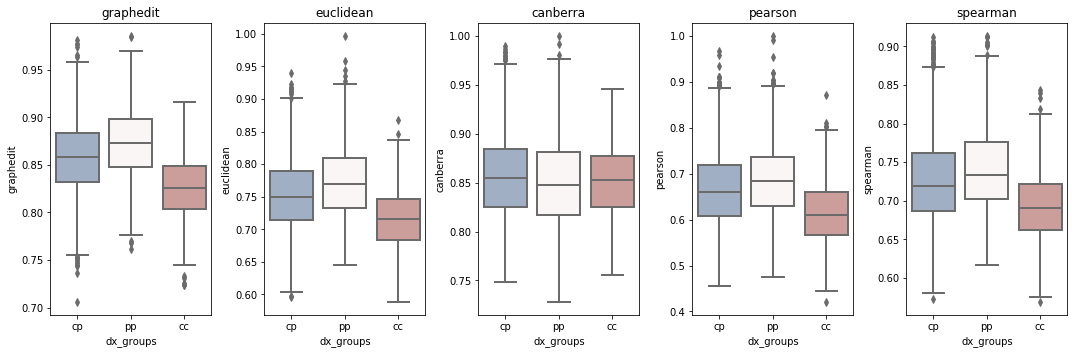

In [117]:
# Box plot
df_dist_sub = df_dist[(df_dist['dx_groups'] != 'p') & (df_dist['times'] == 's1s1')]
plt.figure(figsize=(15, 5))

for i in range(len(dist_measures)):
    plt.subplot(1, len(dist_measures), i+1)
    params = dict(data=df_dist_sub, x='dx_groups', y=dist_measures[i], order=['cp', 'pp', 'cc'])
    sns.boxplot(palette='vlag', linewidth=2, **params)
    plt.title(dist_measures[i])

plt.tight_layout(pad=1.0)
plt.show()

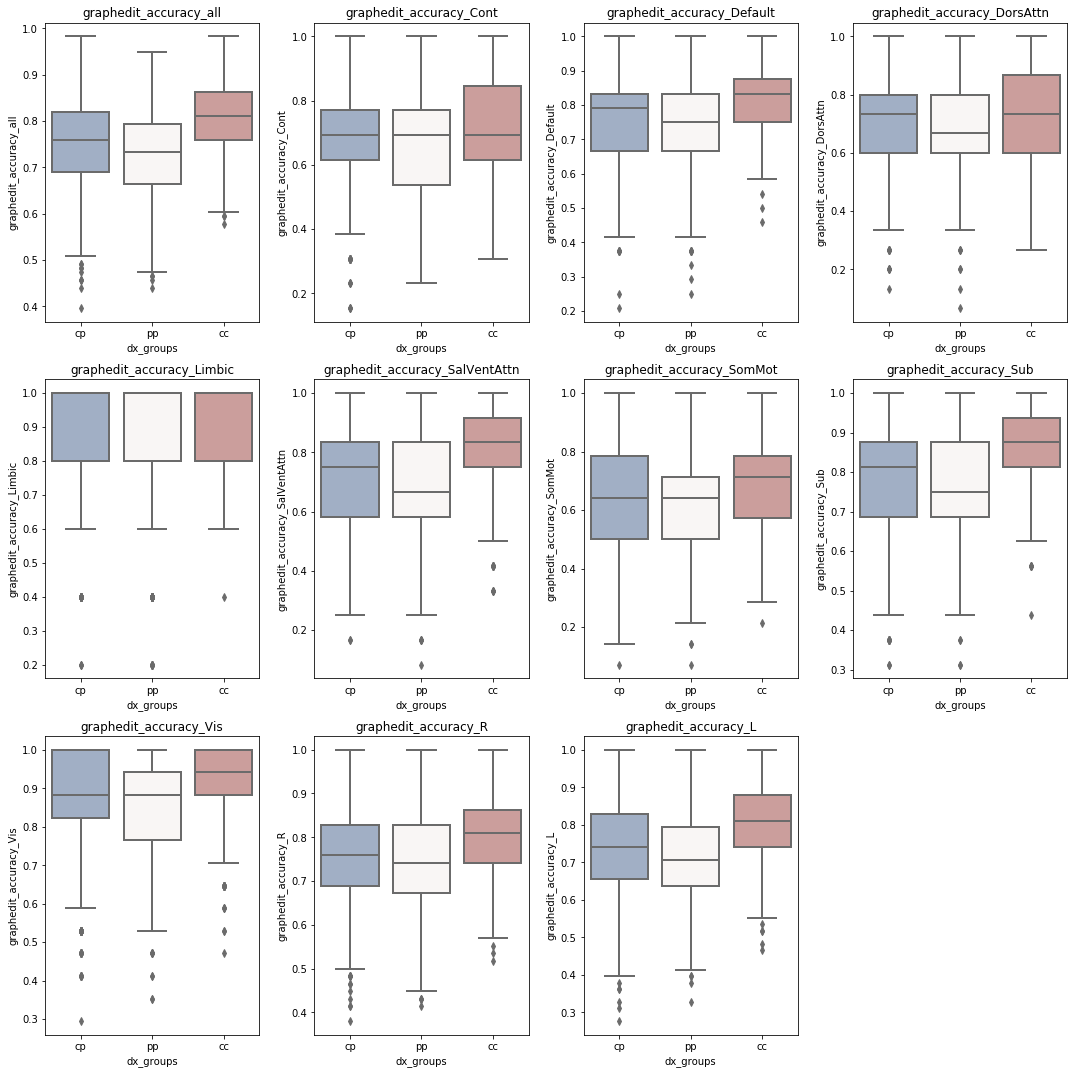

In [120]:
# Box plot
df_dist_sub = df_dist[(df_dist['dx_groups'] != 'p') & (df_dist['times'] == 's1s1')]
plt.figure(figsize=(15, 15))

for i in range(len(accuracy_measures)):
    plt.subplot(3, np.ceil(len(accuracy_measures)/3), i+1)
    params = dict(data=df_dist_sub, x='dx_groups', y=accuracy_measures[i], order=['cp', 'pp', 'cc'])
    sns.boxplot(palette='vlag', linewidth=2, **params)
    plt.title(accuracy_measures[i])

plt.tight_layout(pad=1.0)
plt.show()

### test 2: use all time series

#### Compute:

In [122]:
tests = ['mean(pc)', 'mean(pp)', 'mean(cc)',
         'std(pc)', 'std(pp)', 'std(cc)',
         'Normality_stats(pc)', 'Normality_stats(pp)', 'Normality_stats(cc)',
         'Normality_p(pc)', 'Normality_p(pp)', 'Normality_p(cc)',
         'levene_stats(pc/pp)', 'levene_stats(pc/cc)', 'levene_stats(pp/cc)',
         'levene(pc/pp)', 'levene(pc/cc)', 'levene(pp/cc)',
         't-test_stats(pc/pp)', 't-test_stats(pc/cc)', 't-test_stats(pp/cc)',
         't-test_p(pc/pp)', 't-test_p(pc/cc)', 't-test_p(pp/cc)',
         't-test_es(pc/pp)', 't-test_es(pc/cc)', 't-test_es(pp/cc)',
         'mannwhitneyu_stats(pc/pp)', 'mannwhitneyu_stats(pc/cc)', 'mannwhitneyu_stats(pp/cc)',
         'mannwhitneyu_p(pc/pp)', 'mannwhitneyu_p(pc/cc)', 'mannwhitneyu_p(pp/cc)',
         'mannwhitneyu_es(pc/pp)', 'mannwhitneyu_es(pc/cc)', 'mannwhitneyu_es(pp/cc)',
         'ANOVA_stats', 'ANOVA_p']
df_test = pd.DataFrame({'tests': tests})
dist_measures = ['graphedit', 'euclidean', 'canberra', 'pearson', 'spearman']

for dist_measure in dist_measures+accuracy_measures:
    df_dist[dist_measure] = df_dist[dist_measure]/df_dist[dist_measure].max()
    g0 = df_dist[(df_dist['dx_groups'] == 'cp')][dist_measure]
    g1 = df_dist[(df_dist['dx_groups'] == 'pp')][dist_measure]
    g2 = df_dist[(df_dist['dx_groups'] == 'cc')][dist_measure]
    
    test_score_list = [np.mean(g0), np.mean(g1), np.mean(g2), np.std(g0), np.std(g1), np.std(g2)]

    statistics0, p0 = stats.shapiro(g0)
    statistics1, p1 = stats.shapiro(g1)
    statistics2, p2 = stats.shapiro(g2)
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2]
    
    statistics0, p0 = stats.levene(g0, g1)
    statistics1, p1 = stats.levene(g0, g2)
    statistics2, p2 = stats.levene(g1, g2)
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2]

    statistics0, p0 = stats.ttest_ind(g0, g1, equal_var=False)
    s_pooled=np.sqrt(((len(g0)-1)*np.var(g0)+(len(g1)-1)*np.var(g1))/float(len(g0)+len(g1)-2))
    es0 = (np.mean(g0)-np.mean(g1))/s_pooled
    
    statistics1, p1 = stats.ttest_ind(g0, g2, equal_var=False)
    s_pooled=np.sqrt(((len(g0)-1)*np.var(g0)+(len(g2)-1)*np.var(g2))/float(len(g0)+len(g2)-2))
    es1 = (np.mean(g0)-np.mean(g2))/s_pooled
    
    statistics2, p2 = stats.ttest_ind(g1, g2, equal_var=False)
    s_pooled=np.sqrt(((len(g1)-1)*np.var(g1)+(len(g2)-1)*np.var(g2))/float(len(g1)+len(g2)-2))
    es2 = (np.mean(g1)-np.mean(g2))/s_pooled
    
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2, es0, es1, es2]

    statistics0, p0 = stats.mannwhitneyu(g0, g1, alternative='two-sided')
    m_U = len(g0)*len(g1)/2.0
    std_U = np.sqrt(len(g0)*len(g1)*(len(g0)+len(g1)+1)/12.0)
    z = (statistics0 - m_U) / std_U
    es0 = z / np.sqrt(len(g0)+len(g1))
    
    statistics1, p1 = stats.mannwhitneyu(g0, g2, alternative='two-sided')
    m_U = len(g0)*len(g2)/2.0
    std_U = np.sqrt(len(g0)*len(g2)*(len(g0)+len(g2)+1)/12.0)
    z = (statistics1 - m_U) / std_U
    es1 = z / np.sqrt(len(g0)+len(g2))
    
    statistics2, p2 = stats.mannwhitneyu(g1, g2, alternative='two-sided')
    m_U = len(g1)*len(g2)/2.0
    std_U = np.sqrt(len(g1)*len(g2)*(len(g1)+len(g2)+1)/12.0)
    z = (statistics2 - m_U) / std_U
    es2 = z / np.sqrt(len(g1)+len(g2))
    
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2, es0, es1, es2]
    
    statistics, p = stats.f_oneway(g0, g1, g2)
    test_score_list = test_score_list + [statistics, p]
    
    df_test[dist_measure] = test_score_list

df_test = df_test.set_index('tests')

#### Results:

In [123]:
tests_filter = tests.copy()
tests_filter = [x for x in tests_filter if 'stats' not in x]
df_test.loc[tests_filter][dist_measures]

,graphedit,euclidean,canberra,pearson,spearman
tests,,,,,
mean(pc),8.609979e-01,7.595095e-01,8.519882e-01,6.699116e-01,7.292145e-01
mean(pp),8.784123e-01,7.850334e-01,8.431747e-01,6.933518e-01,7.455284e-01
mean(cc),8.264866e-01,7.154098e-01,8.510193e-01,6.141653e-01,6.930673e-01
std(pc),4.078144e-02,5.900474e-02,4.049648e-02,8.335262e-02,5.730731e-02
std(pp),3.767868e-02,5.857917e-02,4.260327e-02,8.025016e-02,5.587254e-02
std(cc),3.458167e-02,4.700228e-02,3.699761e-02,6.646545e-02,4.648192e-02
Normality_p(pc),3.935579e-01,5.148315e-11,1.787853e-04,4.911888e-11,2.445573e-26
Normality_p(pp),4.445673e-05,7.722514e-14,5.946670e-05,1.576576e-08,4.023276e-29
Normality_p(cc),1.229734e-01,3.482690e-01,4.618594e-02,1.057633e-03,3.133481e-02


In [124]:
tests_filter = tests.copy()
tests_filter = [x for x in tests_filter if 'stats' not in x]
df_test.loc[tests_filter][accuracy_measures]

,graphedit_accuracy_all,graphedit_accuracy_Cont,graphedit_accuracy_Default,graphedit_accuracy_DorsAttn,graphedit_accuracy_Limbic,graphedit_accuracy_SalVentAttn,graphedit_accuracy_SomMot,graphedit_accuracy_Sub,graphedit_accuracy_Vis,graphedit_accuracy_R,graphedit_accuracy_L
tests,,,,,,,,,,,
mean(pc),7.433300e-01,6.739207e-01,7.520514e-01,6.835034e-01,8.611224e-01,7.227679e-01,6.260933e-01,7.938935e-01,8.657113e-01,7.523663e-01,7.342936e-01
mean(pp),7.127823e-01,6.483175e-01,7.127828e-01,6.682475e-01,8.020278e-01,6.863042e-01,6.084219e-01,7.605581e-01,8.347939e-01,7.261426e-01,6.994220e-01
mean(cc),8.069110e-01,7.255333e-01,8.221289e-01,7.331092e-01,9.411765e-01,7.943978e-01,6.839136e-01,8.821429e-01,9.126050e-01,8.072153e-01,8.066068e-01
std(pc),9.411300e-02,1.576216e-01,1.272430e-01,1.540311e-01,1.662883e-01,1.587646e-01,1.641640e-01,1.341352e-01,1.271772e-01,1.051937e-01,1.218686e-01
std(pp),9.395474e-02,1.645475e-01,1.355692e-01,1.568880e-01,2.003655e-01,1.635281e-01,1.610762e-01,1.303841e-01,1.326595e-01,1.121630e-01,1.199650e-01
std(cc),7.485084e-02,1.391848e-01,9.579412e-02,1.420667e-01,1.009299e-01,1.411120e-01,1.545464e-01,9.970507e-02,9.997320e-02,8.392041e-02,1.021825e-01
Normality_p(pc),5.342316e-13,1.869573e-26,4.597331e-25,5.112391e-25,0.000000e+00,1.615649e-32,1.002050e-22,8.725729e-34,0.000000e+00,3.806967e-13,3.050372e-17
Normality_p(pp),8.622994e-12,2.210953e-31,2.205825e-27,9.092412e-30,0.000000e+00,1.186057e-35,2.598626e-27,1.602547e-34,0.000000e+00,1.761540e-15,5.966617e-14
Normality_p(cc),7.222297e-04,1.123946e-10,5.207817e-10,3.706781e-09,2.803334e-35,6.219756e-16,1.733369e-08,3.239196e-19,3.807437e-25,1.136869e-03,1.976046e-07


#### Plots:

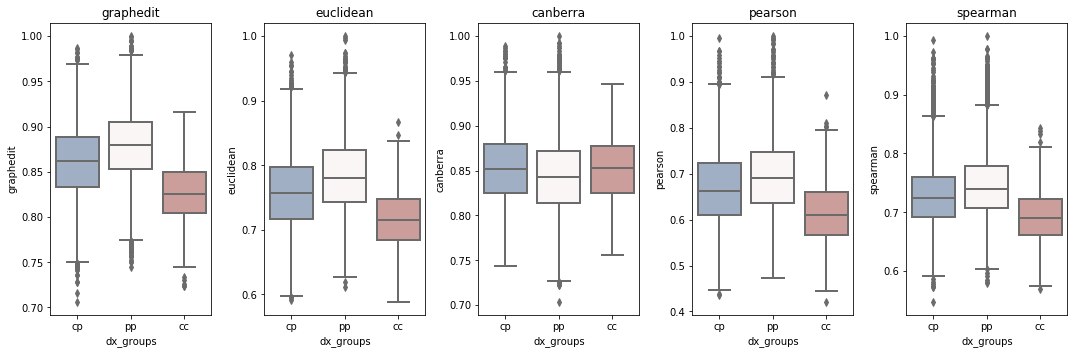

In [126]:
# Box plot
df_dist_sub = df_dist[(df_dist['dx_groups'] != 'p')]
plt.figure(figsize=(15, 5))
dist_measures = ['graphedit', 'euclidean', 'canberra', 'pearson', 'spearman']

for i in range(len(dist_measures)):
    plt.subplot(1, 5, i+1)
    params = dict(data=df_dist_sub, x='dx_groups', y=dist_measures[i], order=['cp', 'pp', 'cc'])
    sns.boxplot(palette='vlag', linewidth=2, **params)
    plt.title(dist_measures[i])

plt.tight_layout(pad=1.0)
plt.show()

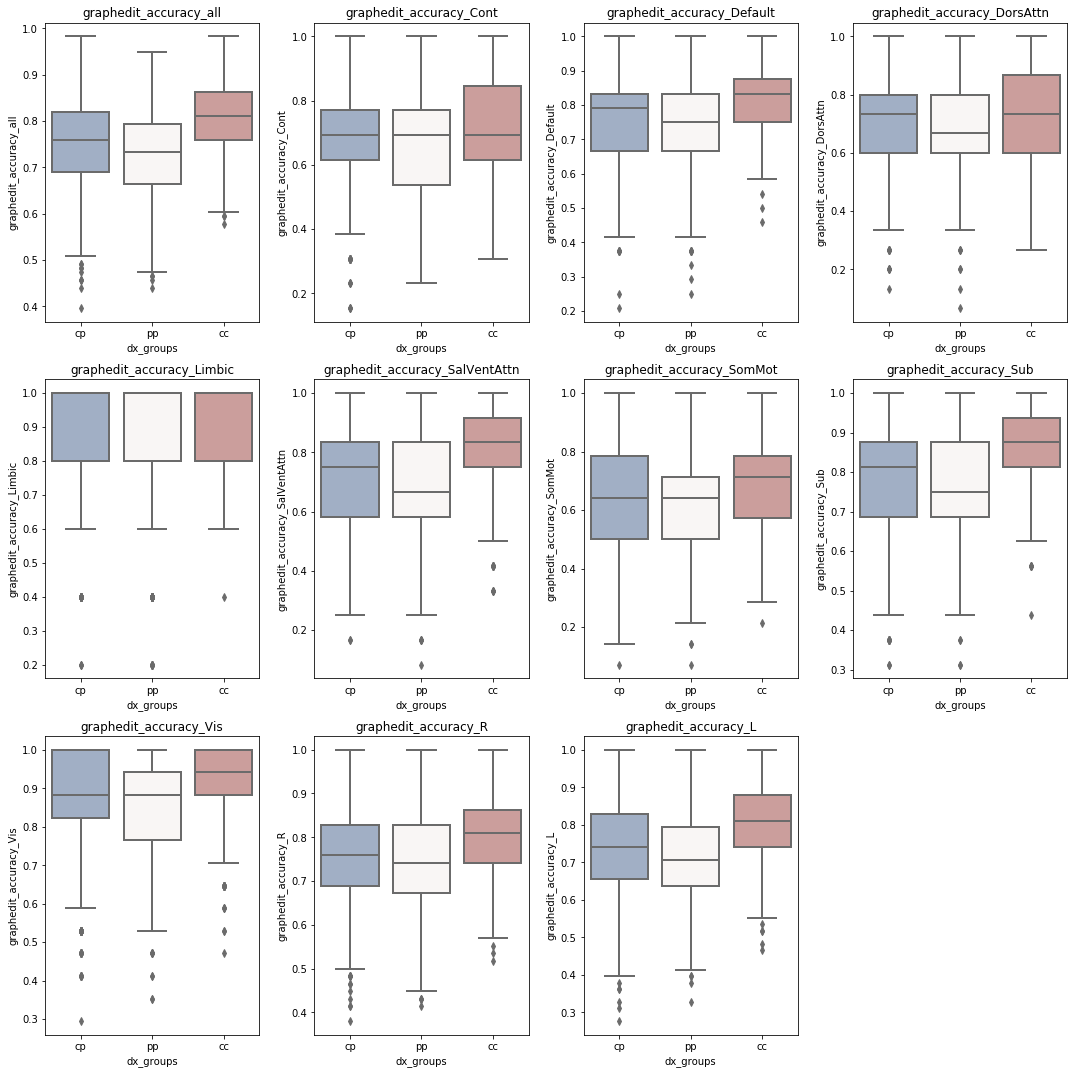

In [125]:
# Box plot
df_dist_sub = df_dist[(df_dist['dx_groups'] != 'p') & (df_dist['times'] == 's1s1')]
plt.figure(figsize=(15, 15))

for i in range(len(accuracy_measures)):
    plt.subplot(3, np.ceil(len(accuracy_measures)/3), i+1)
    params = dict(data=df_dist_sub, x='dx_groups', y=accuracy_measures[i], order=['cp', 'pp', 'cc'])
    sns.boxplot(palette='vlag', linewidth=2, **params)
    plt.title(accuracy_measures[i])

plt.tight_layout(pad=1.0)
plt.show()

### test 3: seperate each time series (control vs patient)

#### Compute:

In [127]:
tests = ['mean(s1s1)', 'mean(s1s2)', 'mean(s1s3)',
         'std(s1s1)', 'std(s1s2)', 'std(s1s3)',
         'Normality_stats(s1s1)', 'Normality_stats(s1s2)', 'Normality_stats(s1s3)',
         'Normality_p(s1s1)', 'Normality_p(s1s2)', 'Normality_p(s1s3)',
         'levene_stats(s1s1/s1s2)', 'levene_stats(s1s1/s1s3)', 'levene_stats(s1s2/s1s3)',
         'levene(s1s1/s1s2)', 'levene(s1s1/s1s3)', 'levene(s1s2/s1s3)',
         't-test_stats(s1s1/s1s2)', 't-test_stats(s1s1/s1s3)', 't-test_stats(s1s2/s1s3)',
         't-test_p(s1s1/s1s2)', 't-test_p(s1s1/s1s3)', 't-test_p(s1s2/s1s3)',
         't-test_es(s1s1/s1s2)', 't-test_es(s1s1/s1s3)', 't-test_es(s1s2/s1s3)',
         'mannwhitneyu_stats(s1s1/s1s2)', 'mannwhitneyu_stats(s1s1/s1s3)', 'mannwhitneyu_stats(s1s2/s1s3)',
         'mannwhitneyu_p(s1s1/s1s2)', 'mannwhitneyu_p(s1s1/s1s3)', 'mannwhitneyu_p(s1s2/s1s3)',
         'mannwhitneyu_es(s1s1/s1s2)', 'mannwhitneyu_es(s1s1/s1s3)', 'mannwhitneyu_es(s1s2/s1s3)',
         'ANOVA_stats', 'ANOVA_p']

df_test = pd.DataFrame({'tests': tests})

dist_measures = ['graphedit', 'euclidean', 'canberra', 'pearson', 'spearman']
for dist_measure in dist_measures+accuracy_measures:
    df_dist[dist_measure] = df_dist[dist_measure]/df_dist[dist_measure].max()
    g0 = df_dist[(df_dist['dx_groups'] == 'cp') & (df_dist['times'] == 's1s1')][dist_measure]
    g1 = df_dist[(df_dist['dx_groups'] == 'cp') & (df_dist['times'] == 's1s2')][dist_measure]
    g2 = df_dist[(df_dist['dx_groups'] == 'cp') & (df_dist['times'] == 's1s3')][dist_measure]
    
    test_score_list = [np.mean(g0), np.mean(g1), np.mean(g2), np.std(g0), np.std(g1), np.std(g2)]

    statistics0, p0 = stats.shapiro(g0)
    statistics1, p1 = stats.shapiro(g1)
    statistics2, p2 = stats.shapiro(g2)
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2]
    
    statistics0, p0 = stats.levene(g0, g1)
    statistics1, p1 = stats.levene(g0, g2)
    statistics2, p2 = stats.levene(g1, g2)
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2]

    statistics0, p0 = stats.ttest_ind(g0, g1, equal_var=False)
    s_pooled=np.sqrt(((len(g0)-1)*np.var(g0)+(len(g1)-1)*np.var(g1))/float(len(g0)+len(g1)-2))
    es0 = (np.mean(g0)-np.mean(g1))/s_pooled
    
    statistics1, p1 = stats.ttest_ind(g0, g2, equal_var=False)
    s_pooled=np.sqrt(((len(g0)-1)*np.var(g0)+(len(g2)-1)*np.var(g2))/float(len(g0)+len(g2)-2))
    es1 = (np.mean(g0)-np.mean(g2))/s_pooled
    
    statistics2, p2 = stats.ttest_ind(g1, g2, equal_var=False)
    s_pooled=np.sqrt(((len(g1)-1)*np.var(g1)+(len(g2)-1)*np.var(g2))/float(len(g1)+len(g2)-2))
    es2 = (np.mean(g1)-np.mean(g2))/s_pooled
    
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2, es0, es1, es2]

    statistics0, p0 = stats.mannwhitneyu(g0, g1, alternative='two-sided')
    m_U = len(g0)*len(g1)/2.0
    std_U = np.sqrt(len(g0)*len(g1)*(len(g0)+len(g1)+1)/12.0)
    z = (statistics0 - m_U) / std_U
    es0 = z / np.sqrt(len(g0)+len(g1))
    
    statistics1, p1 = stats.mannwhitneyu(g0, g2, alternative='two-sided')
    m_U = len(g0)*len(g2)/2.0
    std_U = np.sqrt(len(g0)*len(g2)*(len(g0)+len(g2)+1)/12.0)
    z = (statistics1 - m_U) / std_U
    es1 = z / np.sqrt(len(g0)+len(g2))
    
    statistics2, p2 = stats.mannwhitneyu(g1, g2, alternative='two-sided')
    m_U = len(g1)*len(g2)/2.0
    std_U = np.sqrt(len(g1)*len(g2)*(len(g1)+len(g2)+1)/12.0)
    z = (statistics2 - m_U) / std_U
    es2 = z / np.sqrt(len(g1)+len(g2))
    
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2, es0, es1, es2]
    
    statistics, p = stats.f_oneway(g0, g1, g2)
    test_score_list = test_score_list + [statistics, p]
    
    df_test[dist_measure] = test_score_list
df_test = df_test.set_index('tests')

#### Results:

In [128]:
tests_filter = tests.copy()
tests_filter = [x for x in tests_filter if 'stats' not in x]
df_test.loc[tests_filter][dist_measures]

,graphedit,euclidean,canberra,pearson,spearman
tests,,,,,
mean(s1s1),0.857878,0.753528,0.855882,6.656137e-01,7.273819e-01
mean(s1s2),0.860623,0.761287,0.849801,6.722821e-01,7.288322e-01
mean(s1s3),0.864916,0.764593,0.849681,6.725019e-01,7.316733e-01
std(s1s1),0.039456,0.056508,0.043665,8.238415e-02,5.807748e-02
std(s1s2),0.039519,0.059469,0.038444,8.199319e-02,5.930879e-02
std(s1s3),0.043085,0.060720,0.038296,8.553235e-02,5.427694e-02
Normality_p(s1s1),0.818019,0.000007,0.000114,4.291990e-07,5.970720e-14
Normality_p(s1s2),0.451806,0.000002,0.000220,1.214596e-06,4.328797e-18
Normality_p(s1s3),0.097733,0.000716,0.000125,8.230723e-03,1.080489e-14


In [129]:
tests_filter = tests.copy()
tests_filter = [x for x in tests_filter if 'stats' not in x]
df_test.loc[tests_filter][accuracy_measures]

,graphedit_accuracy_all,graphedit_accuracy_Cont,graphedit_accuracy_Default,graphedit_accuracy_DorsAttn,graphedit_accuracy_Limbic,graphedit_accuracy_SalVentAttn,graphedit_accuracy_SomMot,graphedit_accuracy_Sub,graphedit_accuracy_Vis,graphedit_accuracy_R,graphedit_accuracy_L
tests,,,,,,,,,,,
mean(s1s1),7.501081e-01,6.880729e-01,7.644019e-01,6.908246e-01,8.709408e-01,7.229384e-01,6.347437e-01,7.934669e-01,8.675138e-01,7.603148e-01,7.399015e-01
mean(s1s2),7.437087e-01,6.720879e-01,7.525170e-01,6.763537e-01,8.657959e-01,7.261224e-01,6.226822e-01,7.961735e-01,8.722689e-01,7.501337e-01,7.372836e-01
mean(s1s3),7.352422e-01,6.595849e-01,7.375331e-01,6.821164e-01,8.453968e-01,7.193122e-01,6.195578e-01,7.921627e-01,8.572829e-01,7.454844e-01,7.250000e-01
std(s1s1),9.207803e-02,1.545768e-01,1.219705e-01,1.539624e-01,1.559465e-01,1.599802e-01,1.684249e-01,1.327305e-01,1.296843e-01,1.057095e-01,1.188158e-01
std(s1s2),9.470678e-02,1.563588e-01,1.277838e-01,1.584521e-01,1.584024e-01,1.588727e-01,1.622452e-01,1.376322e-01,1.202356e-01,1.030042e-01,1.227500e-01
std(s1s3),9.519398e-02,1.608595e-01,1.310286e-01,1.493115e-01,1.831889e-01,1.571897e-01,1.606410e-01,1.322382e-01,1.303604e-01,1.061170e-01,1.238882e-01
Normality_p(s1s1),2.088700e-07,2.178379e-16,3.474325e-16,2.744345e-15,1.703138e-41,1.228212e-20,2.171842e-13,2.394524e-20,1.420459e-32,6.044750e-07,1.372534e-08
Normality_p(s1s2),9.358802e-06,1.390522e-14,1.052289e-12,5.920930e-13,1.851487e-38,9.953376e-19,2.527562e-12,1.145733e-20,6.035766e-29,1.357356e-05,6.041409e-09
Normality_p(s1s3),4.166948e-05,8.479446e-14,1.153363e-12,1.286253e-13,5.122713e-38,2.286070e-18,6.335532e-12,1.190179e-19,1.052678e-28,4.527024e-06,8.153850e-09


#### Plots:

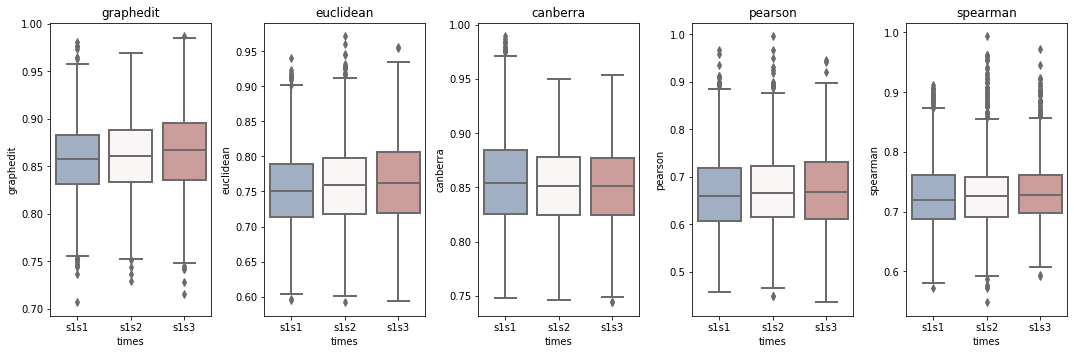

In [131]:
# Box plot
df_dist_sub = df_dist[(df_dist['dx_groups'] == 'cp')]
plt.figure(figsize=(15, 5))
dist_measures = ['graphedit', 'euclidean', 'canberra', 'pearson', 'spearman']

for i in range(len(dist_measures)):
    plt.subplot(1, 5, i+1)
    params = dict(data=df_dist_sub, x='times', y=dist_measures[i], order=['s1s1', 's1s2', 's1s3'])
    sns.boxplot(palette='vlag', linewidth=2, **params)
    plt.title(dist_measures[i])

plt.tight_layout(pad=1.0)
plt.show()

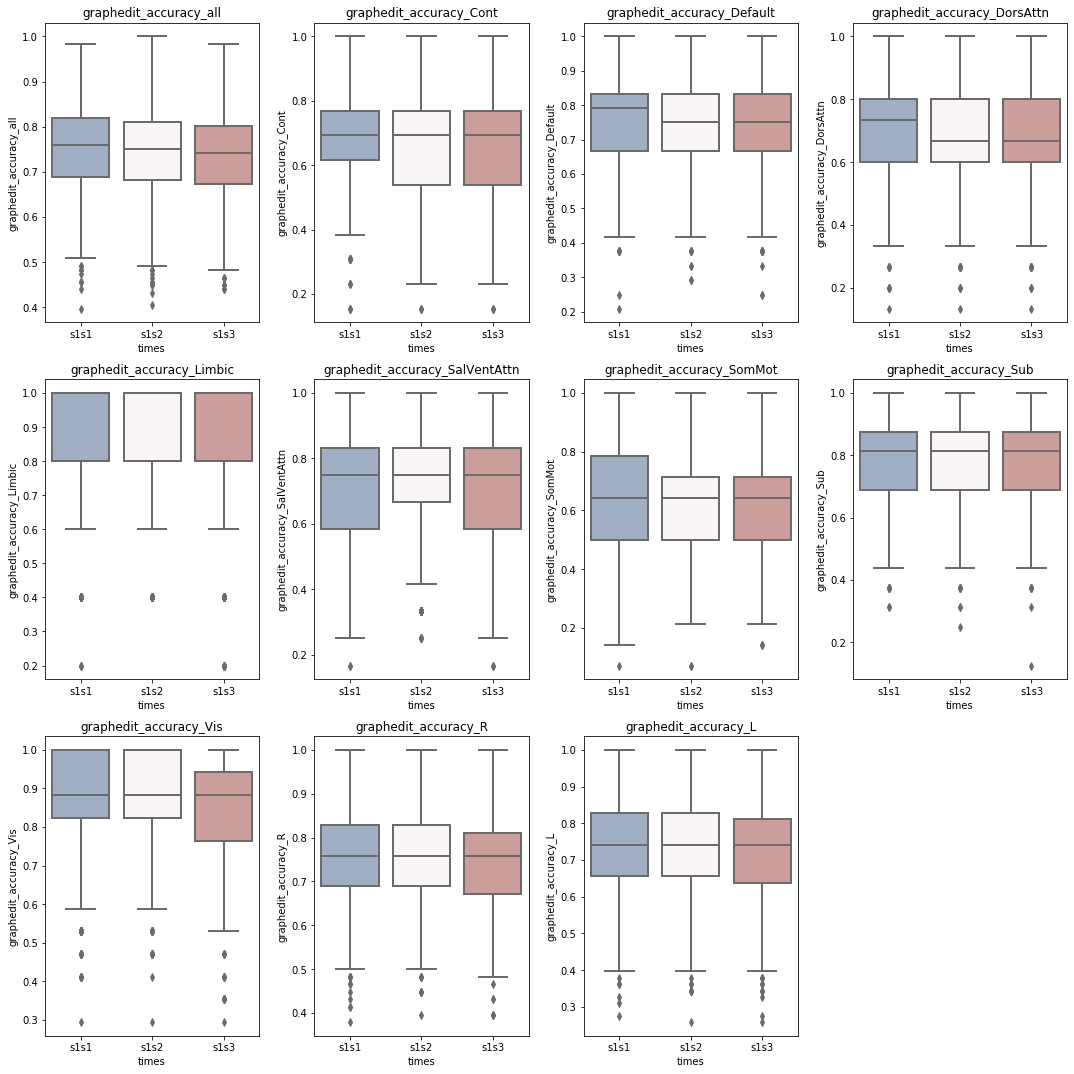

In [133]:
# Box plot
df_dist_sub = df_dist[(df_dist['dx_groups'] == 'cp')]
plt.figure(figsize=(15, 15))

for i in range(len(accuracy_measures)):
    plt.subplot(3, np.ceil(len(accuracy_measures)/3), i+1)
    params = dict(data=df_dist_sub, x='times', y=accuracy_measures[i], order=['s1s1', 's1s2', 's1s3'])
    sns.boxplot(palette='vlag', linewidth=2, **params)
    plt.title(accuracy_measures[i])

plt.tight_layout(pad=1.0)
plt.show()

### test 4: seperate each time series (patient vs patient)

#### Compute:

In [60]:
tests = ['mean(s1s1)', 'mean(s2s2)', 'mean(s3s3)',
         'std(s1s1)', 'std(s2s2)', 'std(s3s3)',
         'Normality_stats(s1s1)', 'Normality_stats(s2s2)', 'Normality_stats(s3s3)',
         'Normality_p(s1s1)', 'Normality_p(s2s2)', 'Normality_p(s3s3)',
         'levene_stats(s1s1/s2s2)', 'levene_stats(s1s1/s3s3)', 'levene_stats(s2s2/s3s3)',
         'levene(s1s1/s2s2)', 'levene(s1s1/s3s3)', 'levene(s2s2/s3s3)',
         't-test_stats(s1s1/s2s2)', 't-test_stats(s1s1/s3s3)', 't-test_stats(s2s2/s3s3)',
         't-test_p(s1s1/s2s2)', 't-test_p(s1s1/s3s3)', 't-test_p(s2s2/s3s3)',
         't-test_es(s1s1/s2s2)', 't-test_es(s1s1/s3s3)', 't-test_es(s2s2/s3s3)',
         'mannwhitneyu_stats(s1s1/s2s2)', 'mannwhitneyu_stats(s1s1/s3s3)', 'mannwhitneyu_stats(s2s2/s3s3)',
         'mannwhitneyu_p(s1s1/s2s2)', 'mannwhitneyu_p(s1s1/s3s3)', 'mannwhitneyu_p(s2s2/s3s3)',
         'mannwhitneyu_es(s1s1/s2s2)', 'mannwhitneyu_es(s1s1/s3s3)', 'mannwhitneyu_es(s2s2/s3s3)',
         'ANOVA_stats', 'ANOVA_p']

df_test = pd.DataFrame({'tests': tests})

dist_measures = ['graphedit', 'graphedit_accuracy', 'euclidean', 'canberra', 'pearson', 'spearman']
for dist_measure in dist_measures:
    df_dist[dist_measure] = df_dist[dist_measure]/df_dist[dist_measure].max()
    g0 = df_dist[(df_dist['dx_groups'] == 'pp') & (df_dist['times'] == 's1s1')][dist_measure]
    g1 = df_dist[(df_dist['dx_groups'] == 'pp') & (df_dist['times'] == 's2s2')][dist_measure]
    g2 = df_dist[(df_dist['dx_groups'] == 'pp') & (df_dist['times'] == 's3s3')][dist_measure]
    
    test_score_list = [np.mean(g0), np.mean(g1), np.mean(g2), np.std(g0), np.std(g1), np.std(g2)]

    statistics0, p0 = stats.shapiro(g0)
    statistics1, p1 = stats.shapiro(g1)
    statistics2, p2 = stats.shapiro(g2)
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2]
    
    statistics0, p0 = stats.levene(g0, g1)
    statistics1, p1 = stats.levene(g0, g2)
    statistics2, p2 = stats.levene(g1, g2)
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2]

    statistics0, p0 = stats.ttest_ind(g0, g1, equal_var=False)
    s_pooled=np.sqrt(((len(g0)-1)*np.var(g0)+(len(g1)-1)*np.var(g1))/float(len(g0)+len(g1)-2))
    es0 = (np.mean(g0)-np.mean(g1))/s_pooled
    
    statistics1, p1 = stats.ttest_ind(g0, g2, equal_var=False)
    s_pooled=np.sqrt(((len(g0)-1)*np.var(g0)+(len(g2)-1)*np.var(g2))/float(len(g0)+len(g2)-2))
    es1 = (np.mean(g0)-np.mean(g2))/s_pooled
    
    statistics2, p2 = stats.ttest_ind(g1, g2, equal_var=False)
    s_pooled=np.sqrt(((len(g1)-1)*np.var(g1)+(len(g2)-1)*np.var(g2))/float(len(g1)+len(g2)-2))
    es2 = (np.mean(g1)-np.mean(g2))/s_pooled
    
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2, es0, es1, es2]

    statistics0, p0 = stats.mannwhitneyu(g0, g1, alternative='two-sided')
    m_U = len(g0)*len(g1)/2.0
    std_U = np.sqrt(len(g0)*len(g1)*(len(g0)+len(g1)+1)/12.0)
    z = (statistics0 - m_U) / std_U
    es0 = z / np.sqrt(len(g0)+len(g1))
    
    statistics1, p1 = stats.mannwhitneyu(g0, g2, alternative='two-sided')
    m_U = len(g0)*len(g2)/2.0
    std_U = np.sqrt(len(g0)*len(g2)*(len(g0)+len(g2)+1)/12.0)
    z = (statistics1 - m_U) / std_U
    es1 = z / np.sqrt(len(g0)+len(g2))
    
    statistics2, p2 = stats.mannwhitneyu(g1, g2, alternative='two-sided')
    m_U = len(g1)*len(g2)/2.0
    std_U = np.sqrt(len(g1)*len(g2)*(len(g1)+len(g2)+1)/12.0)
    z = (statistics2 - m_U) / std_U
    es2 = z / np.sqrt(len(g1)+len(g2))
    
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2, es0, es1, es2]
    
    statistics, p = stats.f_oneway(g0, g1, g2)
    test_score_list = test_score_list + [statistics, p]
    
    df_test[dist_measure] = test_score_list
df_test = df_test.set_index('tests')

#### Results:

In [61]:
tests_filter = tests.copy()
tests_filter = [x for x in tests_filter if 'stats' not in x]
df_test.loc[tests_filter]

,graphedit,graphedit_accuracy,euclidean,canberra,pearson,spearman
tests,,,,,,
mean(s1s1),8.721232e-01,7.263877e-01,7.731475e-01,8.510272e-01,0.684474,7.400862e-01
mean(s2s2),8.780041e-01,7.145465e-01,7.891456e-01,8.387387e-01,0.699189,7.455765e-01
mean(s3s3),8.849827e-01,6.990285e-01,7.930747e-01,8.379302e-01,0.694997,7.509878e-01
std(s1s1),3.608302e-02,9.261416e-02,5.641360e-02,4.543589e-02,0.081052,5.464672e-02
std(s2s2),3.683072e-02,9.361762e-02,6.039574e-02,3.946530e-02,0.079805,5.676895e-02
std(s3s3),3.895684e-02,9.589401e-02,5.797744e-02,4.055692e-02,0.078828,5.553588e-02
Normality_p(s1s1),8.555482e-01,6.152461e-04,5.042764e-05,1.485320e-04,0.001764,2.551868e-08
Normality_p(s2s2),7.535269e-02,7.078877e-02,6.332119e-03,2.799833e-01,0.087711,6.425100e-08
Normality_p(s3s3),1.020545e-01,2.989317e-02,1.143694e-01,7.398007e-03,0.439862,4.355597e-11


#### Plots:

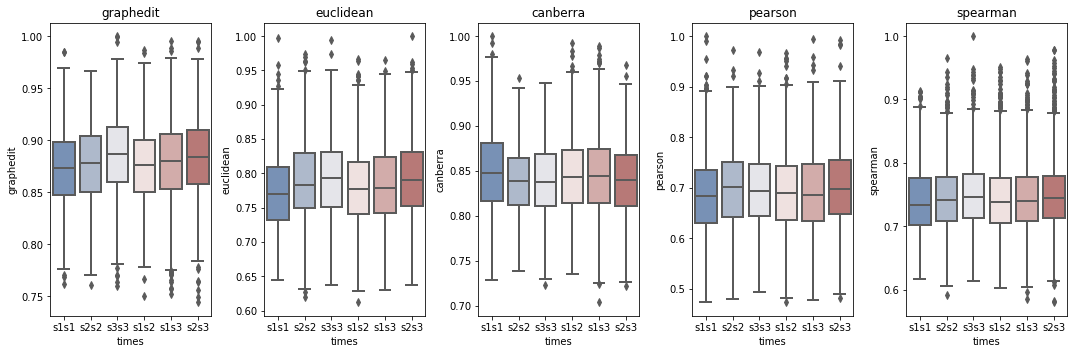

In [62]:
# Box plot
df_dist_sub = df_dist[(df_dist['dx_groups'] == 'pp')]
plt.figure(figsize=(15, 5))
dist_measures = ['graphedit', 'euclidean', 'canberra', 'pearson', 'spearman']

for i in range(len(dist_measures)):
    plt.subplot(1, 5, i+1)
    params = dict(data=df_dist_sub, x='times', y=dist_measures[i], order=['s1s1', 's2s2', 's3s3', 's1s2', 's1s3', 's2s3'])
    sns.boxplot(palette='vlag', linewidth=2, **params)
    plt.title(dist_measures[i])

plt.tight_layout(pad=1.0)
plt.show()

## Intra-subject analysis:

### test 5: seperate each time series (single patient)

#### Compute:

In [63]:
tests = ['mean(s1s2)', 'mean(s1s3)', 'mean(s2s3)',
         'std(s1s2)', 'std(s1s3)', 'std(s2s3)',
         'Normality_stats(s1s2)', 'Normality_stats(s1s3)', 'Normality_stats(s2s3)',
         'Normality_p(s1s2)', 'Normality_p(s1s3)', 'Normality_p(s2s3)',
         'levene_stats(s1s2/s1s3)', 'levene_stats(s1s2/s2s3)', 'levene_stats(s1s3/s2s3)',
         'levene(s1s2/s1s3)', 'levene(s1s2/s2s3)', 'levene(s1s3/s2s3)',
         't-test_stats(s1s2/s1s3)', 't-test_stats(s1s2/s2s3)', 't-test_stats(s1s3/s2s3)',
         't-test_p(s1s2/s1s3)', 't-test_p(s1s2/s2s3)', 't-test_p(s1s3/s2s3)',
         't-test_es(s1s2/s1s3)', 't-test_es(s1s2/s2s3)', 't-test_es(s1s3/s2s3)',
         'mannwhitneyu_stats(s1s2/s1s3)', 'mannwhitneyu_stats(s1s2/s2s3)', 'mannwhitneyu_stats(s1s3/s2s3)',
         'mannwhitneyu_p(s1s2/s1s3)', 'mannwhitneyu_p(s1s2/s2s3)', 'mannwhitneyu_p(s1s3/s2s3)',
         'mannwhitneyu_es(s1s2/s1s3)', 'mannwhitneyu_es(s1s2/s2s3)', 'mannwhitneyu_es(s1s3/s2s3)',
         'ANOVA_stats', 'ANOVA_p']

df_test = pd.DataFrame({'tests': tests})

dist_measures = ['graphedit', 'graphedit_accuracy', 'euclidean', 'canberra', 'pearson', 'spearman']
for dist_measure in dist_measures:
    df_dist[dist_measure] = df_dist[dist_measure]/df_dist[dist_measure].max()
    g0 = df_dist[(df_dist['dx_groups'] == 'p') & (df_dist['times'] == 's1s2')][dist_measure]
    g1 = df_dist[(df_dist['dx_groups'] == 'p') & (df_dist['times'] == 's1s3')][dist_measure]
    g2 = df_dist[(df_dist['dx_groups'] == 'p') & (df_dist['times'] == 's2s3')][dist_measure]
    
    test_score_list = [np.mean(g0), np.mean(g1), np.mean(g2), np.std(g0), np.std(g1), np.std(g2)]

    statistics0, p0 = stats.shapiro(g0)
    statistics1, p1 = stats.shapiro(g1)
    statistics2, p2 = stats.shapiro(g2)
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2]
    
    statistics0, p0 = stats.levene(g0, g1)
    statistics1, p1 = stats.levene(g0, g2)
    statistics2, p2 = stats.levene(g1, g2)
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2]

    statistics0, p0 = stats.ttest_ind(g0, g1, equal_var=False)
    s_pooled=np.sqrt(((len(g0)-1)*np.var(g0)+(len(g1)-1)*np.var(g1))/float(len(g0)+len(g1)-2))
    es0 = (np.mean(g0)-np.mean(g1))/s_pooled
    
    statistics1, p1 = stats.ttest_ind(g0, g2, equal_var=False)
    s_pooled=np.sqrt(((len(g0)-1)*np.var(g0)+(len(g2)-1)*np.var(g2))/float(len(g0)+len(g2)-2))
    es1 = (np.mean(g0)-np.mean(g2))/s_pooled
    
    statistics2, p2 = stats.ttest_ind(g1, g2, equal_var=False)
    s_pooled=np.sqrt(((len(g1)-1)*np.var(g1)+(len(g2)-1)*np.var(g2))/float(len(g1)+len(g2)-2))
    es2 = (np.mean(g1)-np.mean(g2))/s_pooled
    
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2, es0, es1, es2]

    statistics0, p0 = stats.mannwhitneyu(g0, g1, alternative='two-sided')
    m_U = len(g0)*len(g1)/2.0
    std_U = np.sqrt(len(g0)*len(g1)*(len(g0)+len(g1)+1)/12.0)
    z = (statistics0 - m_U) / std_U
    es0 = z / np.sqrt(len(g0)+len(g1))
    
    statistics1, p1 = stats.mannwhitneyu(g0, g2, alternative='two-sided')
    m_U = len(g0)*len(g2)/2.0
    std_U = np.sqrt(len(g0)*len(g2)*(len(g0)+len(g2)+1)/12.0)
    z = (statistics1 - m_U) / std_U
    es1 = z / np.sqrt(len(g0)+len(g2))
    
    statistics2, p2 = stats.mannwhitneyu(g1, g2, alternative='two-sided')
    m_U = len(g1)*len(g2)/2.0
    std_U = np.sqrt(len(g1)*len(g2)*(len(g1)+len(g2)+1)/12.0)
    z = (statistics2 - m_U) / std_U
    es2 = z / np.sqrt(len(g1)+len(g2))
    
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2, es0, es1, es2]
    
    statistics, p = stats.f_oneway(g0, g1, g2)
    test_score_list = test_score_list + [statistics, p]
    
    df_test[dist_measure] = test_score_list
df_test = df_test.set_index('tests')

#### Results:

In [64]:
tests_filter = tests.copy()
tests_filter = [x for x in tests_filter if 'stats' not in x]
df_test.loc[tests_filter]

,graphedit,graphedit_accuracy,euclidean,canberra,pearson,spearman
tests,,,,,,
mean(s1s2),0.706816,0.939655,0.625220,0.766930,0.446974,0.588623
mean(s1s3),0.725408,0.923153,0.638510,0.772033,0.460728,0.606154
mean(s2s3),0.725321,0.917408,0.633946,0.765841,0.453386,0.604880
std(s1s2),0.048611,0.048592,0.049147,0.055938,0.078773,0.044554
std(s1s3),0.054644,0.049559,0.048772,0.055737,0.077182,0.041269
std(s2s3),0.060182,0.063567,0.055224,0.059382,0.087209,0.045661
Normality_p(s1s2),0.160738,0.006089,0.405616,0.785466,0.064596,0.852627
Normality_p(s1s3),0.381276,0.069188,0.600875,0.227009,0.188644,0.569035
Normality_p(s2s3),0.687955,0.011526,0.601853,0.375965,0.751768,0.307174


#### Plots:

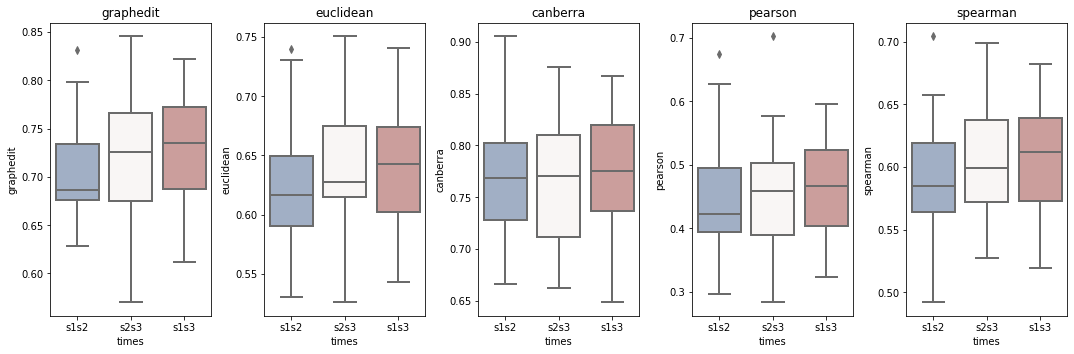

In [65]:
# Box plot
df_dist_sub = df_dist[(df_dist['dx_groups'] == 'p')]
plt.figure(figsize=(15, 5))
dist_measures = ['graphedit', 'euclidean', 'canberra', 'pearson', 'spearman']

for i in range(len(dist_measures)):
    plt.subplot(1, 5, i+1)
    params = dict(data=df_dist_sub, x='times', y=dist_measures[i], order=['s1s2', 's2s3', 's1s3'])
    sns.boxplot(palette='vlag', linewidth=2, **params)
    plt.title(dist_measures[i])

plt.tight_layout(pad=1.0)
plt.show()